In [1]:
import os
import numpy as np
import pandas as pd
from ExKMC.Tree import Tree as ExTree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score as sk_silhouette
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *

from sklearn.metrics import adjusted_rand_score, accuracy_score

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

In [2]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this, aside from font.size:
 
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

### Load Data

In [3]:
seed = 342
np.random.seed(seed)

In [4]:
# Read and process data:
data, data_label_array, feature_labels, scaler = load_preprocessed_anuran('../data/anuran')

'''
import math
size = math.ceil(0.25 * len(data))
random_samples = np.sort(np.random.choice(len(data), size = size, replace = False))
data = data[random_samples, :]
data_label_array = data_label_array[random_samples]
data_labels = labels_format(data_label_array)
'''

# Parameters:
n = data.shape[0]
d = data.shape[1]
k = 10

In [5]:
feature_labels

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21']

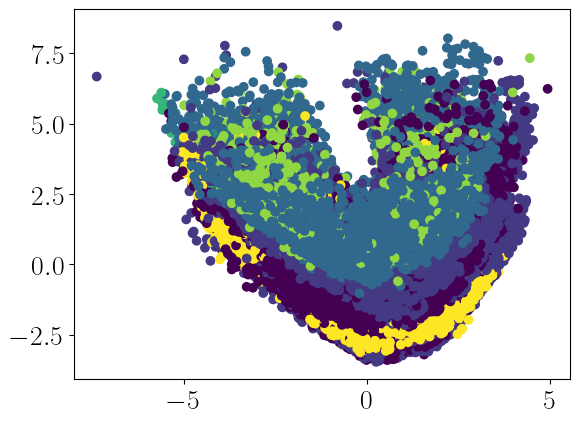

In [6]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(data)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c = data_label_array)

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(data)

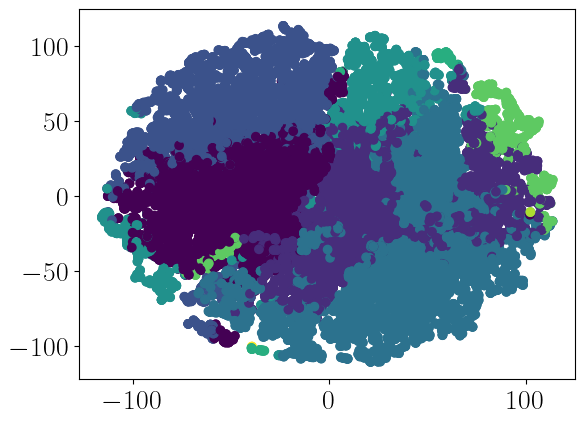

In [67]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = kmeans.labels_)

### KMeans

In [7]:
samples = 10
num_clusters_trials = np.array(list(range(2,20)))
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))
num_clusters_silhouettes = np.zeros((len(num_clusters_trials), samples))


for i, nclusters in enumerate(num_clusters_trials):
    #print(i)
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, normalize = True)
        #silh = sk_silhouette(data, kmeans.labels_)
        num_clusters_costs[i,j] = cost
        #num_clusters_silhouettes[i,j] = silh

Text(0.5, 0, 'Number of clusters')

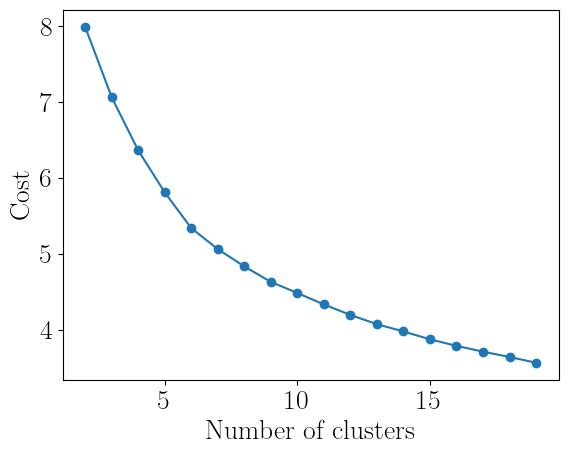

In [8]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

Text(0.5, 0, 'Number of clusters')

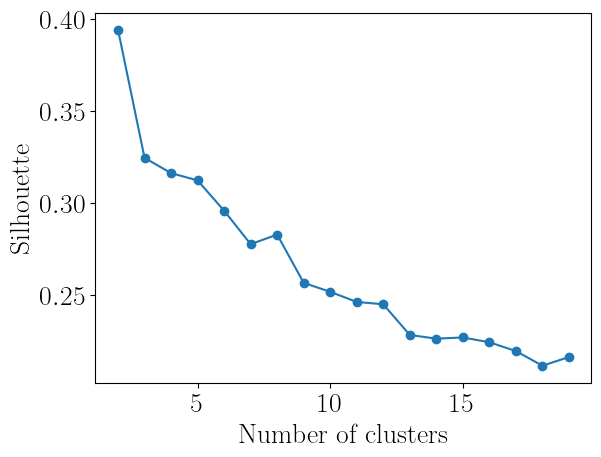

In [ ]:
#plt.plot(num_clusters_trials, np.mean(num_clusters_silhouettes, axis = 1), marker = 'o')
#plt.ylabel('Silhouette')
#plt.xlabel('Number of clusters')

In [8]:
np.random.seed(342)
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, average = True, normalize = True)

7.2516713330413305

### IMM

In [9]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_centers = update_centers(data, kmeans.cluster_centers_, exkmc_assignment)
imm_depth = exkmc_tree.depth
kmeans_cost(data, exkmc_centers, exkmc_assignment, average = True, normalize = True)

8.73185465787021

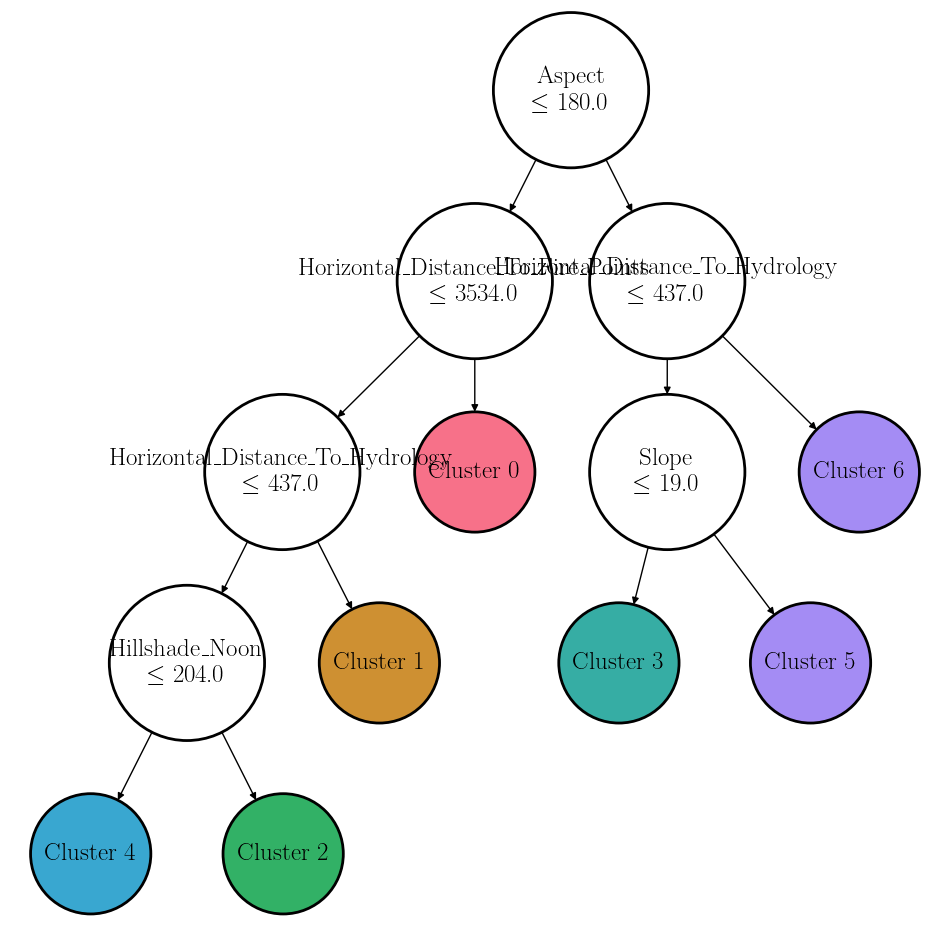

In [16]:
draw_tree(
    root = exkmc_tree.root,
    feature_labels = feature_labels,
    data_scaler = scaler,
    cmap = cmap_subset,
    display_node_info = False,
    output_file = None
)

### Decision Forest

In [71]:
np.random.seed(342)

In [10]:
# Module Parameters:
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 1000
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : [1,2],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# Depth 3 Forest:
forest_tree_params_depth_3 = {
    'max_depth' : 3
}

forest_params_depth_3 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_3,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, 3 + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}


# Depth 4 Forest:
forest_tree_params_depth_4 = {
    'max_depth' : 4
}

forest_params_depth_4 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_4,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, 4 + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : imm_depth
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, imm_depth + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

In [11]:
forest_depth_2 = DecisionForest(**forest_params_depth_2)
forest_depth_2.fit(data, kmeans_labels)

In [15]:
forest_depth_3 = DecisionForest(**forest_params_depth_3)
forest_depth_3.fit(data, kmeans_labels)

In [16]:
forest_depth_4 = DecisionForest(**forest_params_depth_4)
forest_depth_4.fit(data, kmeans_labels)

In [17]:
forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

### Pruning

In [26]:
model = forest_depth_2
search_range = np.linspace(0,5,51)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

Text(0, 0.5, 'Cost')

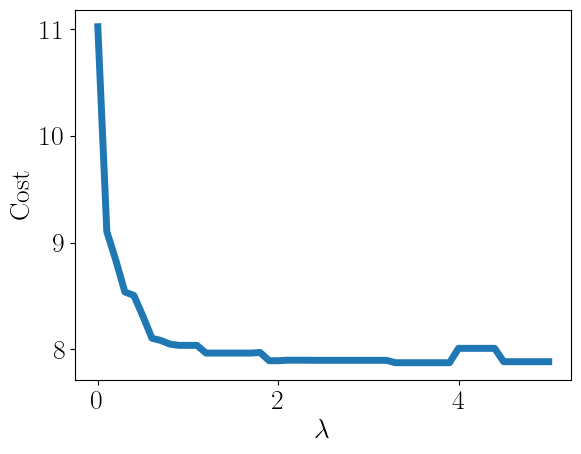

In [27]:
plt.plot(search_range, objective_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

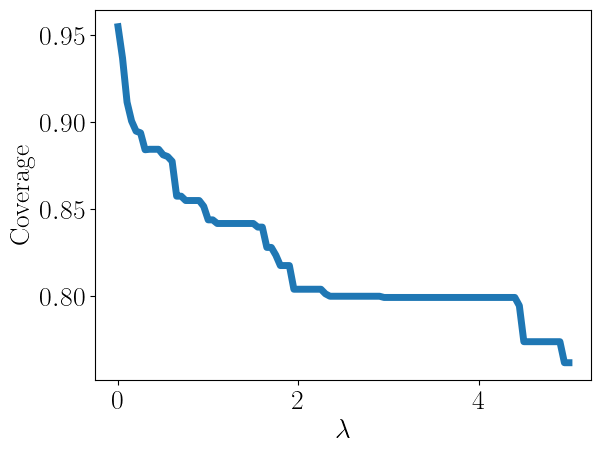

In [23]:
plt.plot(search_range, coverage_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

In [46]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.8,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,5,101),
    'full_search' : True,
    'cpu_count' : 1
}

In [47]:
forest_depth_2.prune(**prune_params)
forest_depth_2_prune_predictions = forest_depth_2.pruned_predict(data, rule_labels = False)

KeyboardInterrupt: 

In [ ]:
forest_depth_3.prune(**prune_params)
forest_depth_3_prune_predictions = forest_depth_2.pruned_predict(data, rule_labels = False)

In [ ]:
forest_depth_4.prune(**prune_params)
forest_depth_4_prune_predictions = forest_depth_4.pruned_predict(data, rule_labels = False)

In [79]:
forest_depth_imm.prune(**prune_params)
forest_depth_imm_prune_predictions = forest_depth_imm.pruned_predict(data, rule_labels = False)

In [80]:
svm_set.prune(**prune_params)
svm_set_prune_predictions = svm_set.pruned_predict(data, rule_labels = False)

### Coverage Distributions

In [85]:
prune_predictions = svm_set_prune_predictions
assignment = labels_to_assignment(
    prune_predictions,
    n_labels = n_clusters
)
distance_ratios = distance_ratio(data, centers)

# Single Covers:
single_cover_mask = np.sum(assignment, axis = 1) == 1
single_cover_distance_ratios = distance_ratios[single_cover_mask]

# Overlaps:
overlap_mask = np.sum(assignment, axis = 1) > 1
overlap_distance_ratios = distance_ratios[overlap_mask]

# Uncovereds:
uncovered_mask = np.sum(assignment, axis = 1) < 1
uncovered_distance_ratios = distance_ratios[uncovered_mask]

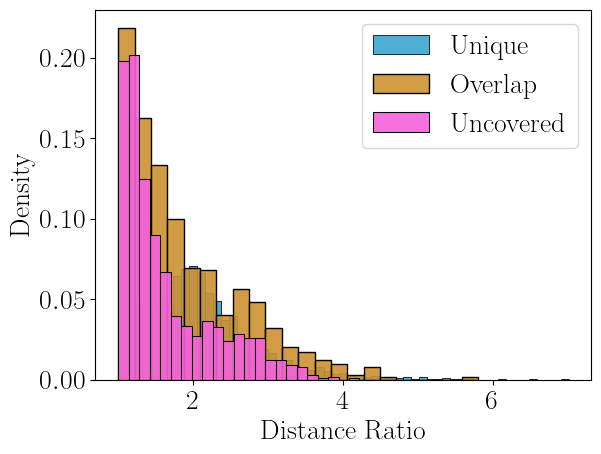

In [86]:
sns.histplot(single_cover_distance_ratios, stat = 'probability', alpha = 0.9, label = "Unique", color = cmap(5))
sns.histplot(overlap_distance_ratios, stat = 'probability', alpha = 0.9, label = "Overlap", color = cmap(1))
sns.histplot(uncovered_distance_ratios, stat = 'probability', alpha = 0.9, label = "Uncovered", color = cmap(7))
plt.ylabel("Density")
plt.xlabel("Distance Ratio")
plt.legend()
plt.savefig('../figures/anuran/svm_cover_dist.png', bbox_inches = 'tight', dpi = 300)